In [1]:
import iris
import iris.quickplot as qplt
import iris.analysis
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# change to your suite-id to pick up the required file
runid='cq988'
datafile='/home/vagrant/cylc-run/u-'+runid+'/work/1/atmos/atmosa.pa19810901_00'
orogfile='/home/vagrant/umdir/ancil/atmos/n48e/orography/globe30/v2/qrparm.orog'

In [3]:
# constraint on time to get 2nd radiation timestep
tconstr=iris.Constraint(time=lambda cell: cell.point.hour == 2)

In [4]:
# load orography to enable correct calculation of level heights
orog=iris.load_cube(orogfile, iris.AttributeConstraint(STASH='m01s00i033'))

In [5]:
# load all extinction components at 0.55 micron
ukca=iris.load_cube(datafile,[iris.Constraint(pseudo_level=3) & iris.AttributeConstraint(STASH='m01s02i530') & tconstr])
classic=iris.load_cube(datafile,[iris.Constraint(pseudo_level=3) & iris.AttributeConstraint(STASH='m01s02i540') & tconstr])

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/pp.py:1562: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t1 = cftime.datetime(
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/pp.py:1597: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t2 = cftime.datetime(
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cf_units/__init__.py:402: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  dates = np.array([dt and dt.replace(microsecond=0) for dt in dates])
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/rules.py:353: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))


In [6]:
# Calculate the correct height of each cell
# add the orography as an auxillary coordinate
auxcoord=iris.coords.AuxCoord(orog.data,standard_name=str(orog.standard_name),long_name="orography",var_name="orog",units=orog.units)
# added in to lat/lon (ht=0,lat=1,lon=2)
ukca.add_aux_coord(auxcoord,(1,2,))
# now calculate the correct altitude above sea-level
factory=iris.aux_factory.HybridHeightFactory(delta=ukca.coord("level_height"),sigma=ukca.coord("sigma"),orography=ukca.coord("surface_altitude"))
# now create the 'altitude' derrived coordinate
ukca.add_aux_factory(factory)
# now calculate the height from the bounds
bounds = ukca.coord('altitude').bounds[:,:,:,1] - ukca.coord('altitude').bounds[:,:,:,0]

In [7]:
# mutliply by the height of each cell 
ukca.data = ukca.data * bounds
classic.data = classic.data * bounds

In [8]:
# now sum up the column
ukca_int=ukca.collapsed('level_height',iris.analysis.SUM)
classic_int=classic.collapsed('level_height',iris.analysis.SUM)

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'model_level_number'.
  warnings.warn(msg.format(self.name()))
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'model_level_number'.
  warnings.warn(msg.format(self.name()))


In [9]:
# add together
aod=ukca_int.copy()
aod.data=np.zeros(aod.data.shape)

aod.data = ukca_int.data + classic_int.data
# rename
aod.rename('atmosphere_optical_thickness_due_to_aerosol')

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


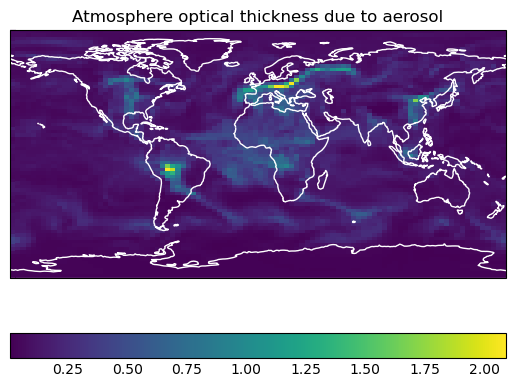

In [10]:
qplt.pcolormesh(aod)
plt.gca().coastlines(color='w')

In [11]:
# output to netCDF
iris.save(aod,'/home/vagrant/iris_Task125_AOD.nc',netcdf_format='NETCDF4')

In [12]:
# now read-in the Task 12.2 field and calculate the difference from this
aod_T122=iris.load_cube('/home/vagrant/iris_Task122_AOD.nc','atmosphere_optical_thickness_due_to_aerosol')

/tmp/ipykernel_9524/2297818383.py:2: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  aod_T122=iris.load_cube('/home/vagrant/iris_Task122_AOD.nc','atmosphere_optical_thickness_due_to_aerosol')


In [13]:
# make cube to store difference in AOD calculation methods
aoddiff=aod.copy()
aoddiff.data=np.zeros(aoddiff.data.shape)

# difference the AODs
aoddiff.data=aod.data-aod_T122.data

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


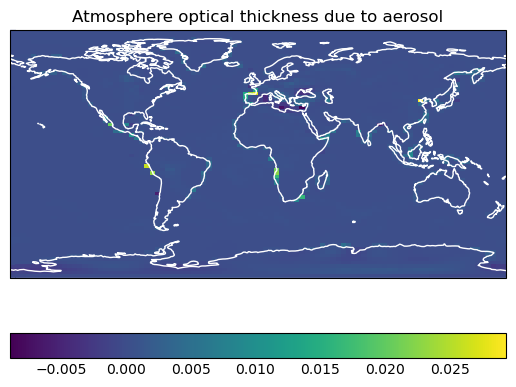

In [14]:
qplt.pcolormesh(aoddiff)
plt.gca().coastlines(color='w')

In [15]:
# output to netCDF
iris.save(aoddiff,'/home/vagrant/iris_Task125_AOD_diff.nc',netcdf_format='NETCDF4')